# **Deep Learning Prediction of Blood Glucose Sharp Peaks:** Delay Times
## **Test**: Determine the Optimal Delay Time for Models

In [1]:
# Downloads
! pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 14.3 MB/s 


In [2]:
# Imports
import numpy as np
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import datetime as dt
from datetime import timedelta
import time
from scipy.signal import savgol_filter, find_peaks
import time
import random as r
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib
from google.colab import drive

### **Part 1:** Set-Up of Dataset
*Contact Jack Lynn (jackrlynn@gmail.com) for log-in credentials.*

In [3]:
# Get dataset
def getData(database, table, server, port):

    # Get username and password
    username = input('Please enter username: ')
    password = getpass('Please enter password: ')

    conn = pymssql.connect(server,username,password,database)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query,conn)
    return df

df = getData("group5database", "dbo.GlucoseMeter",
             "gen10-data-fundamentals-22-05-sql-server.database.windows.net",
             "1433")

Please enter username: jacklynn
Please enter password: ··········


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Text(0, 0.5, 'Blood Glucoose (mmol/L)')

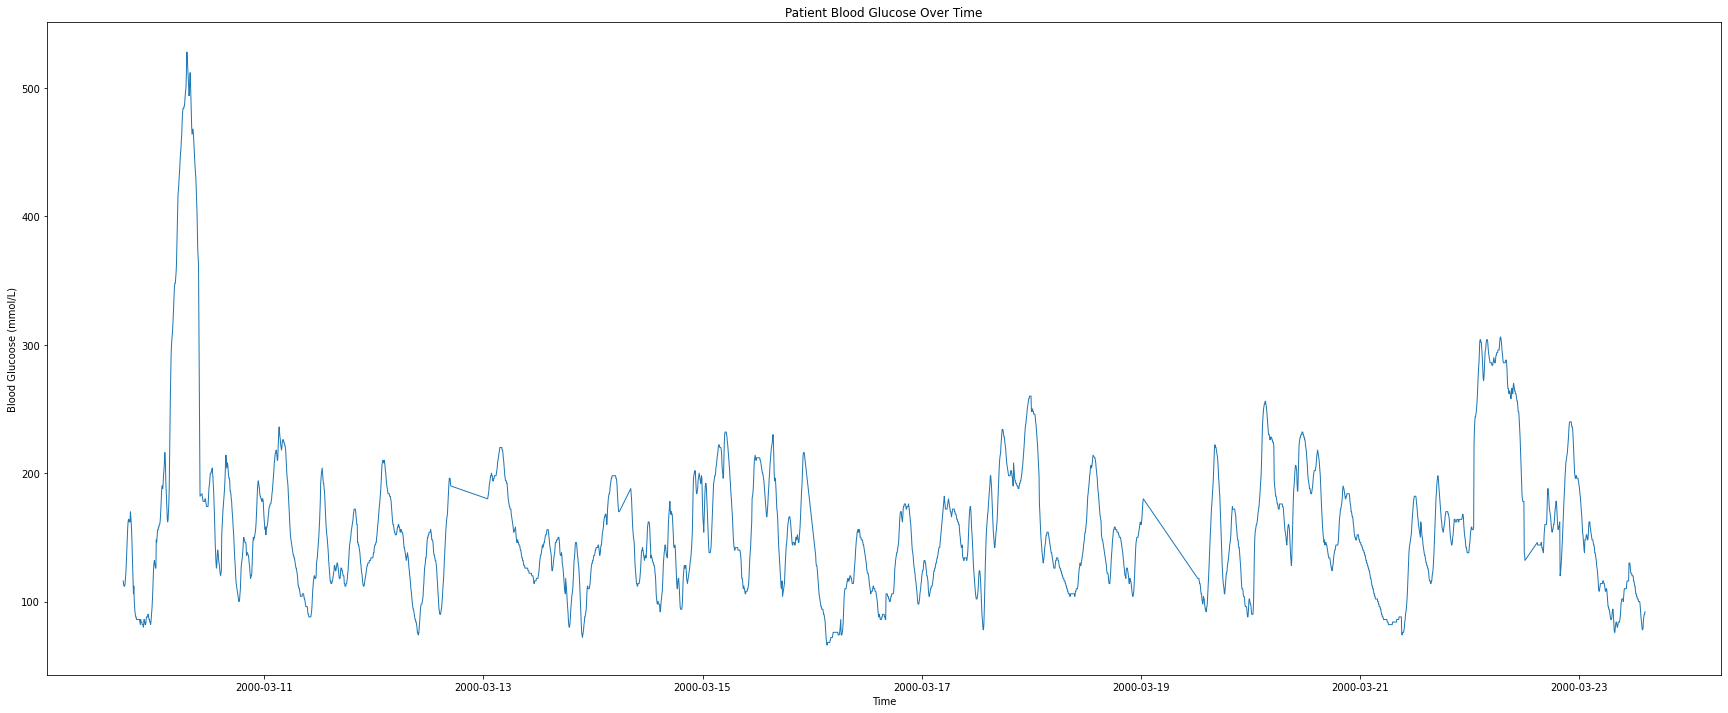

In [4]:
# Display static graphs
%matplotlib inline

# Get each patient
pts = dict()
for ptID in df['ptID'].unique():
  this_df = df[df['ptID'] == ptID]

  # Get only data related to time and glucose_lvl
  this_df = this_df[['time', 'glucose_lvl']]

  # Convert time back into dateime format
  this_df['time']= pd.to_datetime(this_df['time'])

  # Make sure time is in order
  this_df = this_df.sort_values('time')

  # Add patient to dictionary
  pts[ptID] = this_df

# Plot each patient on the same graph
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1)
ax.set_title('Patient Blood Glucose Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucoose (mmol/L)')

In [5]:
# Create list of individual DataFrames
df = pd.DataFrame()
for pt in pts.keys():

  # Format DataFrame
  this_df = pts[pt]
  this_df['pt'] = pt

  # Add to total DataFrame
  if (df.empty):
    df = this_df
  else:
    df = pd.concat([df, this_df], axis=0)

In [6]:
# Create models dictionary for saving tested models
models = dict()
predictions = dict()
timer = dict()

In [7]:
# Split train and test
def splitXandY(df, test_prop=0.2):

  # Create train-test split
  df_test_pts = r.choices(df['pt'].unique(), k=int(test_prop*len(df['pt'].unique())))
  df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))
  df_test = df.loc[df['pt'].isin(df_test_pts)]
  df_train = df.loc[df['pt'].isin(df_train_pts)]

  # Return split
  return [df_train, df_test]

In [8]:
# Prepare the data
df_train, df_test = splitXandY(df)
minMax = MinMaxScaler(feature_range=(-1, 1))
df_train = df_train.drop(columns=['time', 'pt'])
df_test = df_test.drop(columns=['time', 'pt'])

In [9]:
# Convert into 3D shape with window size preview
window = 30
X = []
y = []
y_unf = df_train['glucose_lvl'].to_list()
j = 0
for i in range(window, len(df_train)):
  X.append(df_train.iloc[(i-window):i])
  y.append([y_unf[i]])
X = np.array(X)
y = np.array(y)

In [10]:
# Convert into 3D shape with window size preview
window = 30
X_test = []
y_test = []
y_unf = df_test['glucose_lvl'].to_list()
j = 0
for i in range(window, len(df_test)):
  X_test.append(df_test.iloc[(i-window):i])
  y_test.append(y_unf[i])
X_test = np.array(X)
y_test = np.array(y)

### **Part 3:** Test Different Delay Times

In [11]:
# Initialize model
model_i = keras.models.Sequential()

# Add layers
model_i.add(keras.layers.LSTM(units=50, return_sequences=True,
                            input_shape=(X.shape[1], X.shape[2])))
model_i.add(keras.layers.Dense(25, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.LSTM(units=25, return_sequences=True))
model_i.add(keras.layers.Dense(10, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.LSTM(units=10, return_sequences=True))
model_i.add(keras.layers.Dense(5, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.LSTM(units=5, return_sequences=True))
model_i.add(keras.layers.Flatten())
model_i.add(keras.layers.Dense(1, activation='linear'))

# Compile model with optimizer and loss function
model_i.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# Allow for early exit
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,
                                   patience=10)

model_i.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dense (Dense)               (None, 30, 25)            1275      
                                                                 
 dropout (Dropout)           (None, 30, 25)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 25)            5100      
                                                                 
 dense_1 (Dense)             (None, 30, 10)            260       
                                                                 
 dropout_1 (Dropout)         (None, 30, 10)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 10)            8

In [12]:
# Iterate through different time delays
for i in range(0, 25, 1):

  print(f'Executing: {i*5} Time Delay')

  # Start timer
  t_init = time.time()

  # Create time-delay
  X_i = X[:len(X)-i]
  y_i = y[i:]

  # Train model
  model = keras.models.clone_model(model_i)
  model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
  m = model.fit(X_i, y_i, epochs=10, batch_size=500, callbacks=[es])

  # Get prediction
  X_test_i = X_test[:len(X_test)-i]
  y_pred = m.model.predict(X_test_i)

  # End timer
  t_end = time.time()

  # Models
  models[f'Time Delay {i*5}'] = m
  predictions[f'Time Delay {i*5}'] = y_pred
  timer[f'Time Delay {i*5}'] = t_end - t_init

Executing: 0 Time Delay
Epoch 1/10
1268/1268 [==============================] - 30s 15ms/step - loss: 13855.5273 - mean_squared_error: 13855.5273
Epoch 2/10
1268/1268 [==============================] - 17s 14ms/step - loss: 5887.5195 - mean_squared_error: 5887.5195
Epoch 3/10
1268/1268 [==============================] - 17s 14ms/step - loss: 5818.9141 - mean_squared_error: 5818.9141
Epoch 4/10
1268/1268 [==============================] - 18s 14ms/step - loss: 4145.6768 - mean_squared_error: 4145.6768
Epoch 5/10
1268/1268 [==============================] - 17s 14ms/step - loss: 892.3758 - mean_squared_error: 892.3758
Epoch 6/10
1268/1268 [==============================] - 17s 14ms/step - loss: 549.9201 - mean_squared_error: 549.9201
Epoch 7/10
1268/1268 [==============================] - 18s 14ms/step - loss: 424.4975 - mean_squared_error: 424.4975
Epoch 8/10
1268/1268 [==============================] - 17s 14ms/step - loss: 355.0416 - mean_squared_error: 355.0416
Epoch 9/10
1268/1268 [

### **Part 3:** Visualize Models

(0.0, 350.0)

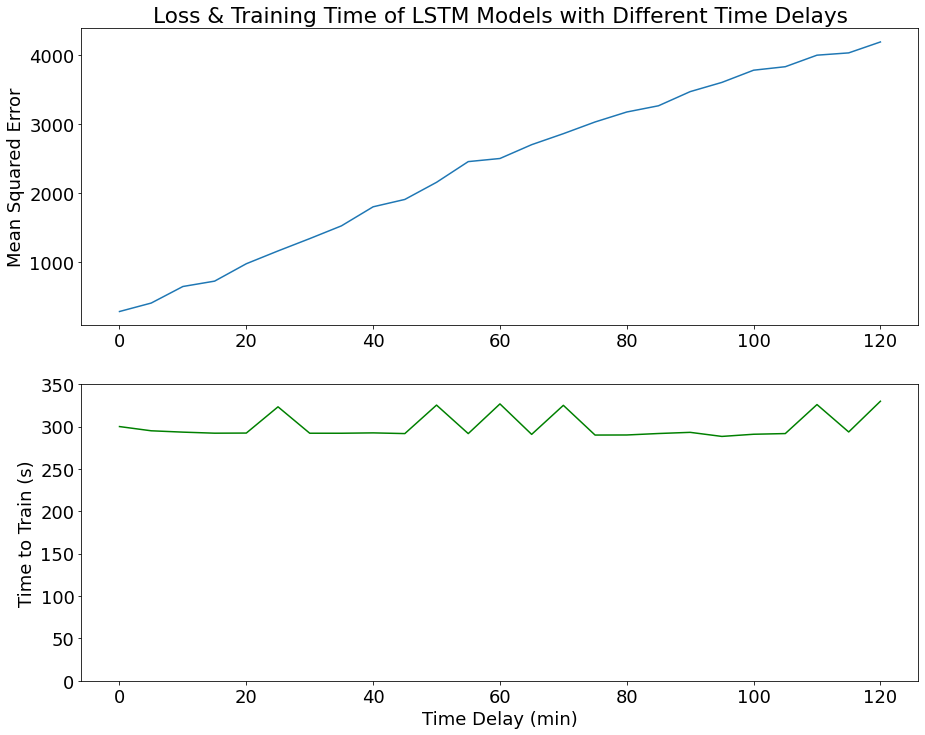

In [18]:
# Plot mean squared errors
fig, axs = plt.subplots(2, figsize=(15, 12))

# Get loss values
loss = list(map(lambda key : models[key].history['loss'][-1], models.keys()))
time_delays = list(range(0, 121, 5))
times = list(map(lambda key : timer[key], timer.keys()))

# Plot these values
axs[0].plot(time_delays, loss)
axs[1].plot(time_delays, times, color='green')

# Add in plot features
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
axs[0].set_title('Loss & Training Time of LSTM Models with Different Time Delays')
#axs[0].set_xlabel('Time Delay (min)')
axs[0].set_ylabel('Mean Squared Error')

# Add in plot features
axs[1].set_xlabel('Time Delay (min)')
axs[1].set_ylabel('Time to Train (s)')
axs[1].set_ylim([0, 350])

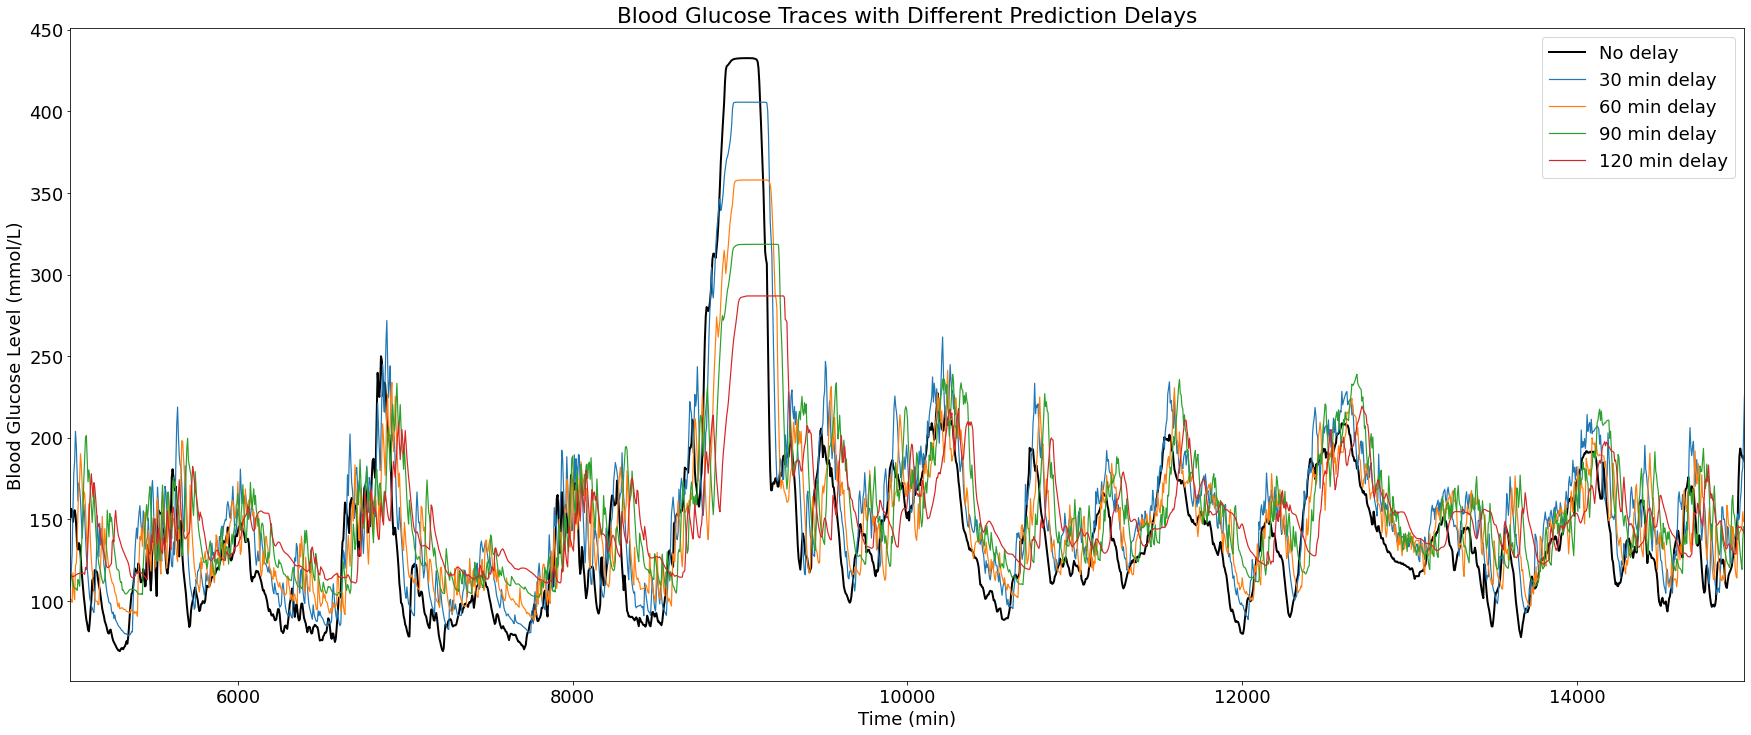

In [19]:
# Plot actual traces as proof of concept
fig, ax = plt.subplots(figsize=(30, 12))

# Plot different predictions on the same graph
time_values = list(range(5000, 15001, 5))
for i in range(0, 121, 30):
  prediction = predictions[f'Time Delay {i}']
  offset = i // 5
  if (i == 0):
    ax.plot(time_values, prediction[1000-offset:3001-offset], label=f'No delay',
            linewidth=2.0, color='black')
  else:
    ax.plot(time_values, prediction[1000-offset:3001-offset], label=f'{i} min delay',
            linewidth=1.2)

# Add labels
ax.set_ylabel('Blood Glucose Level (mmol/L)')
ax.set_xlabel('Time (min)')
ax.set_title('Blood Glucose Traces with Different Prediction Delays')
ax.set_xlim([5000, 15000])
ax.legend()

### **Part 4:** Save Models

In [15]:
# Prepare models
i = 1
for key in models.keys():
  model = models[key]
  model.model.save(f'delay_time_{i}')
  i += 1

In [17]:
# Copy to drive
drive.mount('/content/drive')
!cp -r delay_time_1/ "/content/drive/My Drive/"
!cp -r delay_time_2/ "/content/drive/My Drive/"
!cp -r delay_time_3/ "/content/drive/My Drive/"
!cp -r delay_time_4/ "/content/drive/My Drive/"
!cp -r delay_time_5/ "/content/drive/My Drive/"
!cp -r delay_time_6/ "/content/drive/My Drive/"
!cp -r delay_time_7/ "/content/drive/My Drive/"
!cp -r delay_time_8/ "/content/drive/My Drive/"
!cp -r delay_time_9/ "/content/drive/My Drive/"
!cp -r delay_time_10/ "/content/drive/My Drive/"
!cp -r delay_time_11/ "/content/drive/My Drive/"
!cp -r delay_time_12/ "/content/drive/My Drive/"
!cp -r delay_time_13/ "/content/drive/My Drive/"
!cp -r delay_time_14/ "/content/drive/My Drive/"
!cp -r delay_time_15/ "/content/drive/My Drive/"
!cp -r delay_time_16/ "/content/drive/My Drive/"
!cp -r delay_time_17/ "/content/drive/My Drive/"
!cp -r delay_time_18/ "/content/drive/My Drive/"
!cp -r delay_time_19/ "/content/drive/My Drive/"
!cp -r delay_time_20/ "/content/drive/My Drive/"
!cp -r delay_time_21/ "/content/drive/My Drive/"
!cp -r delay_time_22/ "/content/drive/My Drive/"
!cp -r delay_time_23/ "/content/drive/My Drive/"
!cp -r delay_time_24/ "/content/drive/My Drive/"

Mounted at /content/drive
